# Exercise 1b: Estimating the uncertainty of income specific footprints for Germany using Monte-Carlo simulations

## Introduction

In Exercise 6 we calculated income-specific footprints for German households. You might still remember that we used consumption data for 10 income groups, which came with 2 columns: One stating the **average** consumption per sector, and one stating the **standard deviation**. The standard deviation (SD) is a measure of the amount of variation or uncertainty of a set of values. High SDs mean we have a high uncertainty of this value, low SDs mean we are rather certain about a value.   
Back then, we ignored the 'standard deviation'-column and just took the average value. 

In this week's exercise, we are using now both, the average and the standard deviation to estimate the uncertainty of the income-specific footprints. 


## Import libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import pymrio
import os
from plotnine import *
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Specify paths

It's good practice to specify all paths at the beginning of your script so that other people who want to run your script directly know which lines to adapt to run the script in their own computer. 

In [2]:
data_folder = '../data' # path to the data folder where you stored the "Final_demand_by_income_*.xlsx"  files
path2exiobase = '/home/simon/Documents/PhD_PROSET/data/EXIOBASE3/V3.8.2/IOT_2015_pxp.zip' # path to the exiobase file

## Step 1: Load data on final demand by income group

Now, we read both dataframes using pandas `read_excel()` function. Note that we have to specify that the first two columns ([0,1] in python) store the indices. 

In [3]:
Y_avg = pd.read_excel(os.path.join(data_folder, 'Final_demand_by_income_avg.xlsx'), index_col=[0,1], header=0)
Y_std = pd.read_excel(os.path.join(data_folder, 'Final_demand_by_income_std.xlsx'), index_col=[0,1], header=0)

Let's have a look, how the data looks like: 

In [4]:
Y_avg

Group00_Average_HH  \
region sector                                                                  
AT     Paddy rice                                                   0.000000   
       Wheat                                                        0.131622   
       Cereal grains nec                                            0.087608   
       Vegetables, fruit, nuts                                      1.879902   
       Oil seeds                                                    0.494576   
...                                                                      ...   
WM     Membership organisation services n.e.c. (91)                 0.000000   
       Recreational, cultural and sporting services (92)            0.515412   
       Other services (93)                                          0.247414   
       Private households with employed persons (95)                0.000000   
       Extra-territorial organizations and bodies                   0.000000   

                                                          Group01_Below_900  \
region sector                                                                 
AT     Paddy rice                                                  0.000000   
       Wheat                                                       0.058911   
       Cereal grains nec                                           0.040518   
       Vegetables, fruit, nuts                                     0.835712   
       Oil seeds                                                   0.241321   
...                                                                     ...   
WM     Membership organisation services n.e.c. (91)                0.000000   
       Recreational, cultural and sporting services (92)           0.122105   
       Other services (93)                                         0.054800   
       Private households with employed persons (95)               0.000000   
       Extra-territorial organizations and bodies                  0.000000   

                                                          Group02_Below_1300  \
region sector                                                                  
AT     Paddy rice                                                   0.000000   
       Wheat                                                        0.072158   
       Cereal grains nec                                            0.049630   
       Vegetables, fruit, nuts                                      1.023637   
       Oil seeds                                                    0.295587   
...                                                                      ...   
WM     Membership organisation services n.e.c. (91)                 0.000000   
       Recreational, cultural and sporting services (92)            0.207948   
       Other services (93)                                          0.083465   
       Private households with employed persons (95)                0.000000   
       Extra-territorial organizations and bodies                   0.000000   

                                                          Group03_Below_1500  \
region sector                                                                  
AT     Paddy rice                                                   0.000000   
       Wheat                                                        0.082732   
       Cereal grains nec                                            0.056902   
       Vegetables, fruit, nuts                                      1.173631   
       Oil seeds                                                    0.338899   
...                                                                      ...   
WM     Membership organisation services n.e.c. (91)                 0.000000   
       Recreational, cultural and sporting services (92)            0.276817   
       Other services (93)                                          0.110604   
       Private households with employed persons (95)                

Note that the column index does not have a name yet. This could cause some troubles later. Thus we provide a name for it (`income_group`): 

In [5]:
Y_avg.columns.name = 'income_group'
Y_std.columns.name = 'income_group'

## Step 2: Generate random final demand matrices

Now, we have two pieces of information for each data point: the average (or mean), and the standard deviation. We use this information to draw a sufficiently large number of random samples for each data point. Thus, we create a sufficiently large number of random variants of the income-specific final demand matrices.

For doing so, we define a function that takes two matrices and the number of samples `N` as inputs and delivers a list of length `N` containing random variants of the income-specific final demand matrix. 

Since, there is not negative consumption we cannot use the `normal` distribution to draw the samples. Instead we use the `lognormal` distribution: 

In [6]:
def generate_sample_matrices(mean_matrix, std_dev_matrix, N):
    # Get the shape of the mean matrix
    shape = mean_matrix.shape
    
    # Initialize an empty list to store the generated sample matrices
    sample_matrices = []
    
    # Loop N times to generate N sample matrices
    for _ in range(N):
        # Generate a sample matrix with log-normal distribution
        samples = np.random.lognormal(mean_matrix, std_dev_matrix)
        
        # Take the natural logarithm of the sample matrix
        samples = np.log(samples)
        
        # Convert the sample matrix to a pandas DataFrame
        samples = pd.DataFrame(samples, index=mean_matrix.index, columns=mean_matrix.columns)
        
        # Replace any infinite values with zeros
        samples = samples.replace([np.inf, -np.inf], 0)
        
        # Append the cleaned sample matrix to the list
        sample_matrices.append(samples)
    
    # Return the list of generated sample matrices
    return sample_matrices


Now, we define the number of samples we want to draw: 

In [7]:
N = 200

... and call the `generate_sample_matrices()`-function: 

In [8]:
Y_samples = generate_sample_matrices(Y_avg, Y_std, N)

In [9]:
Y_samples[1]

income_group                                              Group00_Average_HH  \
region sector                                                                  
AT     Paddy rice                                                   0.000000   
       Wheat                                                        0.130333   
       Cereal grains nec                                            0.090272   
       Vegetables, fruit, nuts                                      1.824643   
       Oil seeds                                                    0.493806   
...                                                                      ...   
WM     Membership organisation services n.e.c. (91)                 0.000000   
       Recreational, cultural and sporting services (92)            0.494843   
       Other services (93)                                          0.239653   
       Private households with employed persons (95)                0.000000   
       Extra-territorial organizations and bodies                   0.000000   

income_group                                              Group01_Below_900  \
region sector                                                                 
AT     Paddy rice                                                  0.000000   
       Wheat                                                       0.057773   
       Cereal grains nec                                           0.041641   
       Vegetables, fruit, nuts                                     0.853293   
       Oil seeds                                                   0.238840   
...                                                                     ...   
WM     Membership organisation services n.e.c. (91)                0.000000   
       Recreational, cultural and sporting services (92)           0.127418   
       Other services (93)                                         0.059742   
       Private households with employed persons (95)               0.000000   
       Extra-territorial organizations and bodies                  0.000000   

income_group                                              Group02_Below_1300  \
region sector                                                                  
AT     Paddy rice                                                   0.000000   
       Wheat                                                        0.071974   
       Cereal grains nec                                            0.051416   
       Vegetables, fruit, nuts                                      1.097965   
       Oil seeds                                                    0.312913   
...                                                                      ...   
WM     Membership organisation services n.e.c. (91)                 0.000000   
       Recreational, cultural and sporting services (92)            0.208060   
       Other services (93)                                          0.092164   
       Private households with employed persons (95)                0.000000   
       Extra-territorial organizations and bodies                   0.000000   

income_group                                              Group03_Below_1500  \
region sector                                                                  
AT     Paddy rice                                                   0.000000   
       Wheat                                                        0.083215   
       Cereal grains nec                                            0.058311   
       Vegetables, fruit, nuts                                      1.124326   
       Oil seeds                                                    0.352900   
...                                                                      ...   
WM     Membership organisation services n.e.c. (91)                 0.000000   
       Recreational, cultural and sporting services (92)            0.280506   
       Other services (93)                                          0.122214   
       Pri

## Step 3: Plot the distribtions of indiviual data values

We look at some individual data points to check if everything has worked like intended: 

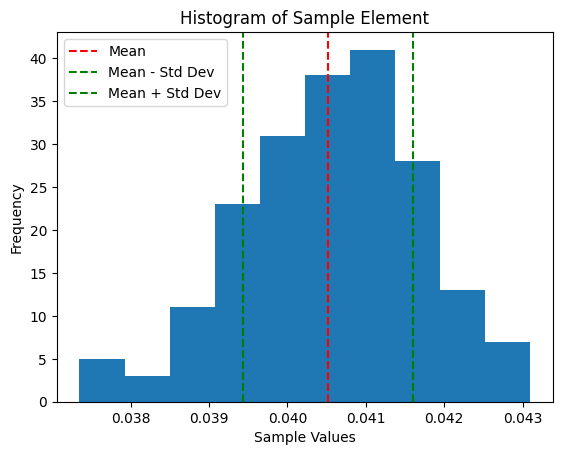

In [10]:
# choose a random non-zero (!) row (region-sector) and column (income group). 
# Repeat with 3-4 different row/col combinations
row = 2
col = 1


plt.hist(np.array(Y_samples)[:,row,col])
plt.xlabel('Sample Values')
plt.ylabel('Frequency')
plt.title('Histogram of Sample Element')

mean_value = Y_avg.iloc[row,col]
std_dev = Y_std.iloc[row,col]

plt.axvline(mean_value, color='r', linestyle='--', label='Mean')
plt.axvline(mean_value - std_dev, color='g', linestyle='--', label='Mean - Std Dev')
plt.axvline(mean_value + std_dev, color='g', linestyle='--', label='Mean + Std Dev')

plt.legend()
plt.show()


## Step 4: Import Exiobase and calculate missing elements

As we already did in Exercise 1a we load (parse) the 2013 version of EXIOBASE: 

In [11]:
exio = pymrio.parse_exiobase3(path2exiobase)

Now, let's calculate all missing parts from our MRIO system (L, S, ...):

In [12]:
exio.calc_system()

Check dimensions of the three matrices first: 

In [13]:
print("S: ", exio.impacts.S.shape)
print("L: ", exio.L.shape)
print("Y: ", Y_samples[0].shape)


S:  (126, 9800)
L:  (9800, 9800)
Y:  (9800, 12)


## Step 5: Calculate total footprints by income


We extract the GWP100 GHG emissions from the S-matrix: '['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)']'

In [14]:
S = exio.impacts.S.loc[['GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)']]
S

region                                                     AT                \
sector                                             Paddy rice         Wheat   
impact                                                                        
GHG emissions (GWP100) | Problem oriented appro...          0  1.797268e+06   

region                                                                \
sector                                             Cereal grains nec   
impact                                                                 
GHG emissions (GWP100) | Problem oriented appro...      1.098151e+06   

region                                                                      \
sector                                             Vegetables, fruit, nuts   
impact                                                                       
GHG emissions (GWP100) | Problem oriented appro...             214702.4762   

region                                                            \
sector                                                 Oil seeds   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  1.352845e+06   

region                                                                     \
sector                                             Sugar cane, sugar beet   
impact                                                                      
GHG emissions (GWP100) | Problem oriented appro...           2.023974e+06   

region                                                                 \
sector                                             Plant-based fibers   
impact                                                                  
GHG emissions (GWP100) | Problem oriented appro...       363928.43653   

region                                                            \
sector                                                 Crops nec   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  1.160058e+06   

region                                                            \
sector                                                    Cattle   
impact                                                             
GHG emissions (GWP100) | Problem oriented appro...  6.161796e+06   

region                                                             ...  \
sector                                                       Pigs  ...   
impact                                                             ...   
GHG emissions (GWP100) | Problem oriented appro...  503415.686986  ...   

region                                                                        WM  \
sector                                             Paper for treatment: landfill   
impact                                                                             
GHG emissions (GWP100) | Problem oriented appro...                  1.934802e+07   

region                                                                                    \
sector                                             Plastic waste for treatment: landfill   
impact                                                                                     
GHG emissions (GWP100) | Problem oriented appro...                          1.360299e+06   

region                                                                                                  \
sector                                             Inert/metal/hazardous waste for treatment: landfill   
impact                                                                                                   
GHG emissions (GWP100) | Problem oriented appro...                                      186200.380643    

region                                                                                     \
sector                                             Textiles waste for treatment: landfill   
impact                                        

This time we define a function to calculate footprints. The function takes the matrices $S$, $L$ and $Y$ as inputs and multiplies the three matrices:  

In [15]:
def calculate_footprints(S, L, Y): 
    footprints = S.dot(L.dot(Y))
    return(footprints)

Then, we calculate footprints for each random variant of the income-specific final demand matrix. The other two elements, namely the stressor matrix $S$ and the Leontief matrix $L$ we assume to be constant. Thus, we only quantify the uncertainty steming from the variability in the Final demand matrix. 

We calcualate the footprints using a for-loop: 

In [16]:
# Create an empty list to store the footprints:
D_samples = []
for i in tqdm(range(len(Y_samples))):
    D = calculate_footprints(S, exio.L, Y_samples[i])
    D_samples.append(D)

  0%|          | 0/200 [00:00<?, ?it/s]

## Step 6: Process, analyse and plot results

The footprints are now stored in a list (`D_samples`) with one entry per iteration:

In [17]:
D_samples[0]

income_group,Group00_Average_HH,Group01_Below_900,Group02_Below_1300,Group03_Below_1500,Group04_Below_1700,Group05_Below_2000,Group06_Below_2600,Group07_Below_3600,Group08_Below_5000,Group09_Below_7500,Group10_Below_10000,Group11_Below_18000
impact,,,,,,,,,,,,
"GHG emissions (GWP100) | Problem oriented approach: baseline (CML, 2001) | GWP100 (IPCC, 2007)",1.020177e+10,3.846377e+09,5.213175e+09,5.985273e+09,6.649981e+09,7.628637e+09,8.843530e+09,1.083961e+10,1.254064e+10,1.462385e+10,1.752649e+10,2.053065e+10


To analyse the distributions of the footprints and plot them, it is more convenient to bind the list elements together into one large DataFrame:  

In [18]:
D_df = pd.concat(D_samples, ignore_index=True)
D_df

income_group,Group00_Average_HH,Group01_Below_900,Group02_Below_1300,Group03_Below_1500,Group04_Below_1700,Group05_Below_2000,Group06_Below_2600,Group07_Below_3600,Group08_Below_5000,Group09_Below_7500,Group10_Below_10000,Group11_Below_18000
0,1.020177e+10,3.846377e+09,5.213175e+09,5.985273e+09,6.649981e+09,7.628637e+09,8.843530e+09,1.083961e+10,1.254064e+10,1.462385e+10,1.752649e+10,2.053065e+10
1,1.022819e+10,3.829623e+09,5.277310e+09,5.951488e+09,6.570768e+09,7.667808e+09,8.928154e+09,1.082362e+10,1.259783e+10,1.456439e+10,1.768050e+10,2.063880e+10
2,1.030969e+10,3.855651e+09,5.208972e+09,6.305787e+09,6.617244e+09,7.578409e+09,8.920188e+09,1.097433e+10,1.238963e+10,1.444616e+10,1.757947e+10,2.038412e+10
3,1.015386e+10,3.822797e+09,5.229183e+09,6.040474e+09,6.652495e+09,7.681670e+09,8.815154e+09,1.102505e+10,1.253845e+10,1.450176e+10,1.756954e+10,2.062115e+10
4,1.027636e+10,3.812302e+09,5.220332e+09,6.111332e+09,6.597858e+09,7.553747e+09,8.681792e+09,1.086010e+10,1.342885e+10,1.457288e+10,1.776727e+10,2.057242e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
195,1.017680e+10,3.836956e+09,4.920175e+09,6.308638e+09,6.574880e+09,7.695517e+09,8.947897e+09,1.102278e+10,1.328530e+10,1.468084e+10,1.750899e+10,2.033250e+10
196,1.033410e+10,3.815050e+09,5.208090e+09,6.043102e+09,6.599944e+09,7.465726e+09,8.809040e+09,1.105306e+10,1.337928e+10,1.535743e+10,1.765320e+10,2.032122e+10
197,1.026559e+10,3.835173e+09,5.201477e+09,5.969392e+09,6.590567e+09,7.566673e+09,8.956856e+09,1.085403e+10,1.331130e+10,1.464755e+10,1.727166e+10,2.048918e+10
198,1.025339e+10,3.864132e+09,5.158869e+09,6.295165e+09,6.625038e+09,7.640280e+09,8.990581e+09,1.086412e+10,1.328861e+10,1.474070e+10,1.768347e+10,2.035483e+10


Then, we convert the DataFrame from wide to long format (see: https://towardsdatascience.com/reshaping-a-pandas-dataframe-long-to-wide-and-vice-versa-517c7f0995ad): 

In [19]:
D_df = pd.melt(D_df, ignore_index=False)
D_df

,income_group,value
0,Group00_Average_HH,1.020177e+10
1,Group00_Average_HH,1.022819e+10
2,Group00_Average_HH,1.030969e+10
3,Group00_Average_HH,1.015386e+10
4,Group00_Average_HH,1.027636e+10
...,...,...
195,Group11_Below_18000,2.033250e+10
196,Group11_Below_18000,2.032122e+10
197,Group11_Below_18000,2.048918e+10
198,Group11_Below_18000,2.035483e+10


Convert emissions from kg to Mt: 

In [20]:
D_df['value_Mt'] = D_df['value'] / 1E9

`D_df` now contains `N` rows for each income group. One row per sample (or Monte-Carlo run). 

### 1. Plot the footprints by income group using a bar plot with an error bar covering the 95% uncertainty interval

In order to plot the data, we first have to make some summary statistics over all samples (or Monte-Carlo runs). Therefore, we group the data by the 'income_group' column using `.groupby('income_group')`. Then we aggregate the column 'value' using `.agg`. The aggregation is speficied within the `.agg`-function: `.agg({'value': np.mean, np.std, lambda x: np.quantile(x, 0.975),lambda x: np.quantile(x, 0.025)]}`. The np.mean and np.std functions are used to calculate the mean and standard deviation, respectively. The lambda function with np.quantile(x, 0.975) calculates the 97.5th percentile of 'x' within each group.


In [21]:
D_summary = D_df.groupby('income_group').agg({'value_Mt': 
                                               [
                                                np.mean, 
                                                np.std, 
                                                lambda x: np.quantile(x, 0.975), 
                                                lambda x: np.quantile(x, 0.025)   
                                               ]})
D_summary.columns = ['mean', 'sd', 'q975', 'q025']
D_summary.reset_index(inplace=True)

Now, we can plot the data using our prefered plot library and plot type. Here, we use ggplot to make a barplot with errorbars: 

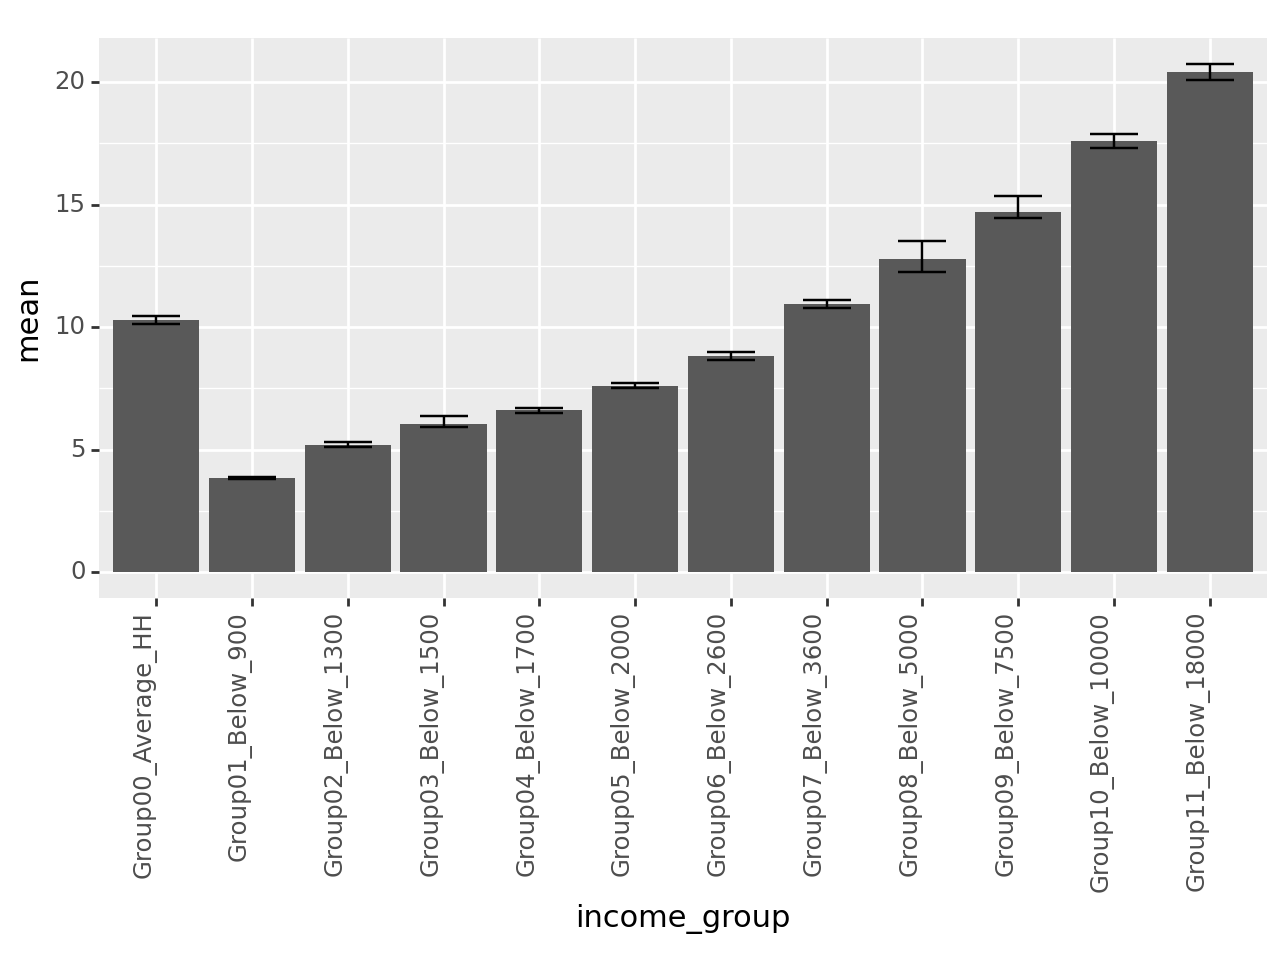

<Figure Size: (640 x 480)>

In [22]:
(
ggplot(D_summary, aes(x = 'income_group', y = 'mean', ymin = 'q025', ymax = 'q975')) + 
    geom_col() + 
    geom_errorbar()+ 
    theme(axis_text_x=element_text(rotation=90, hjust=1))
)

### 2. Plot the distributions of the footprints by income group using a boxplot or violin plot. 
Plot distributions:

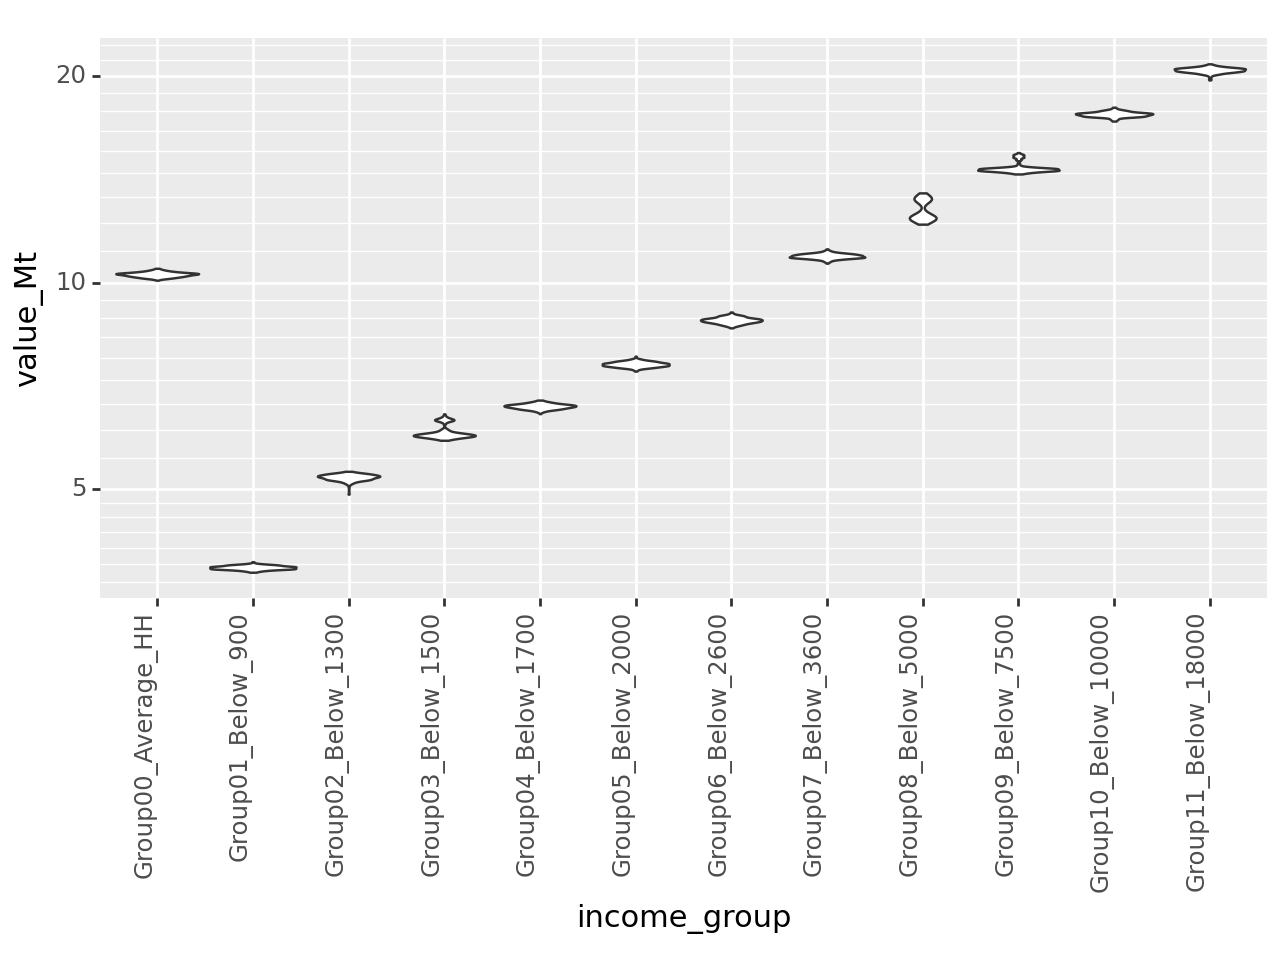

<Figure Size: (640 x 480)>

In [23]:
(
ggplot(D_df, aes(x = 'income_group', y = 'value_Mt')) + 
    geom_violin() + 
    scale_y_log10()+ 
    theme(axis_text_x=element_text(rotation=90, hjust=1))
)

### 3. What is the GHG-footprint of the lowest and highest income group, repectively? Provide the average (mean) number and the uncertainty range.
 Provide the average (mean) number and the uncertainty range. If the uncertainty range is symmetric around the mean note them as: $mean \pm sd$. If the uncertainty is skewed (=not symmetric) write them as $mean^{+ (q975-mean)}_{-(mean-q025)}$. Round to an appropriate decimal place.

In [24]:
D_summary['q975_rel'] = D_summary['q975'] - D_summary['mean']
D_summary['q025_rel'] = D_summary['mean'] - D_summary['q025']

In [25]:
D_summary.set_index('income_group', inplace=True)

In [26]:
D_summary.loc['Group01_Below_900'].round(2)

mean        3.85
sd          0.02
q975        3.89
q025        3.80
q975_rel    0.05
q025_rel    0.05
Name: Group01_Below_900, dtype: float64

The GHG footprint of the lowest income group (income < 900 Euro) is $4.16^{+0.06}_{-0.05}$ Mt.  

In [27]:
D_summary.loc['Group11_Below_18000'].round(2)

mean        20.43
sd           0.18
q975        20.74
q025        20.10
q975_rel     0.32
q025_rel     0.33
Name: Group11_Below_18000, dtype: float64

The GHG footprint of the lowest income group (income < 900 Euro) is $22.96^{+0.38}_{-0.50}$ Mt. 

### 4. Which income group has the footprint with the highest relative uncertainty?


In [28]:
D_summary['rel_sd'] = D_summary['sd'] / D_summary['mean'] # calculate the relative standard deviation (coefficient of variation)
D_summary.sort_values('rel_sd', inplace=True, ascending=False) # sort the data frame by the relative standard deviation
D_summary   # print the data frame

,mean,sd,q975,q025,q975_rel,q025_rel,rel_sd
income_group,,,,,,,
Group08_Below_5000,12.764369,0.429150,13.499154,12.239512,0.734784,0.524858,0.033621
Group03_Below_1500,6.058753,0.135613,6.361421,5.919450,0.302669,0.139303,0.022383
Group09_Below_7500,14.711655,0.242297,15.370502,14.456577,0.658847,0.255078,0.016470
Group02_Below_1300,5.208372,0.052943,5.294092,5.097618,0.085720,0.110754,0.010165
Group06_Below_2600,8.820346,0.088535,8.990632,8.654728,0.170285,0.165619,0.010038
Group11_Below_18000,20.428502,0.177126,20.744920,20.096543,0.316418,0.331960,0.008671
Group04_Below_1700,6.608948,0.056281,6.713276,6.497591,0.104327,0.111357,0.008516
Group05_Below_2000,7.609610,0.064748,7.737077,7.497763,0.127468,0.111847,0.008509
Group10_Below_10000,17.616048,0.145238,17.895005,17.315868,0.278956,0.300180,0.008245
